### BSR data processing steps:

1. Pre-processing: group the data by product, yielding historical ranks with corresponding dates
2. Filling Missing data
  - calculated the distribution of MAX consecutive null value for each product
  - selected 30 as the threshold for removing products with consecutive nan
  - filled the consecutive null with MEAN value before and after it
3. Smoothing
  - calculated 10-day rolling median BSR rank
  - calculated median/mean over each month
4. Normalization
  - Normalize product BSR against its best performance: i.e. for each product, first compute its maximum and minimum BSR observed in the dataset; then, for product i on date t, compute (BSR_{i,t} - min BSR)/(max BSR - min BSR) to represent product i's performance compared with its past performance.
  - Calculated normalized value for each quantity in the previous steps
5. post-processing

Resulting dataset has each row on product-month level. Output to `clean/month_level_rank.csv`.

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
import os
os.chdir('/content/drive/MyDrive/297R-Caps-Pattern/')

In [23]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [24]:
!ls

 Data	     'Meeting Notes'  'Pattern SoW Draft.gdoc'
 Manuscript   Notebooks        Presentations


In [25]:
# input folders
in_data = "/content/drive/MyDrive/297R-Caps-Pattern/Data/clean"
# output folders
out_data = "/content/drive/MyDrive/297R-Caps-Pattern/Data/clean"

In [26]:
# load bsr datasets
bsr_full = pd.read_csv(f'{in_data}/bsr.csv')

In [27]:
bsr_full

,dat_prod_key,asin,date,rank,avg180_price
0,1004,B00R7FFYO8,2017-07-03,768.857143,41.393333
1,33,B00R7FFYO8,2017-07-04,767.000000,41.393333
2,54,B00R7FFYO8,2017-07-05,860.625000,41.393333
3,381,B00R7FFYO8,2017-07-06,919.500000,41.393333
4,1266,B00R7FFYO8,2017-07-07,981.285714,41.393333
...,...,...,...,...,...
10263311,10483729,B07Y41M5H8,2019-10-17,NaN,NaN
10263312,10483730,B07Y41M5H8,2019-10-19,NaN,NaN
10263313,10483731,B07Y41M5H8,2019-10-20,NaN,NaN
10263314,10483732,B07Y41M5H8,2019-10-21,NaN,NaN


In [28]:
# Sorting by date
bsr_sorted = bsr_full.sort_values('date')
bsr_sorted.reset_index(inplace=True)

In [29]:
# Grouping by product and creating timelines
bsr_timelines_by_product = bsr_sorted.groupby('asin')['rank'].apply(list).reset_index(name='rank')
bsr_timelines_by_product['date'] = bsr_sorted.groupby('asin')['date'].apply(list).reset_index(name='date')['date']

In [30]:
bsr_timelines_by_product

,asin,rank,date
0,B000052XB5,"[1254.1666666666667, 1137.0, 1216.0, 1345.8571...","[2017-07-03, 2017-07-04, 2017-07-05, 2017-07-0..."
1,B00005313T,"[3805.75, 4089.0, 3478.125, 4052.571428571429,...","[2017-07-03, 2017-07-04, 2017-07-05, 2017-07-0..."
2,B0000533I2,"[8918.0, 9200.0, 10612.333333333334, 9628.0, 9...","[2017-07-03, 2017-07-04, 2017-07-05, 2017-07-0..."
3,B00005K9DO,"[199998.5, 232356.0, 269494.0, nan, nan, nan, ...","[2017-07-03, 2017-07-04, 2017-07-05, 2017-07-0..."
4,B0000645VY,"[4093.75, 3950.857142857143, 4651.75, 4122.142...","[2017-07-03, 2017-07-04, 2017-07-05, 2017-07-0..."
...,...,...,...
9116,B08PDXQJG4,"[114812.0, 206618.0, 161748.66666666666, nan, ...","[2020-12-03, 2020-12-04, 2020-12-05, 2020-12-0..."
9117,B08PH5ZHVC,"[176613.0, 174651.0, 225566.0, 125644.2, 11249...","[2020-12-11, 2020-12-12, 2020-12-13, 2020-12-1..."
9118,B08PQC9VRP,"[191472.3333333333, 135016.33333333334, 194566...","[2020-12-07, 2020-12-08, 2020-12-09, 2020-12-1..."
9119,B08Q2CTFJ3,"[138366.0, 86092.5, 108362.0, 71956.5, 58127.3...","[2020-12-11, 2020-12-12, 2020-12-13, 2020-12-1..."


### Function definition

In [31]:
def fill_na(rank_list):
    rank_df = pd.DataFrame(rank_list,columns=['Rank'])
    rank_df = pd.concat([rank_df.ffill(), rank_df.bfill()]).groupby(level=0).mean()['Rank'].values.tolist()
    return rank_df

def smoothing(rank_list):
  n_days = 10
  rolling = pd.Series(rank_list).rolling(window=n_days)
  rolling_median= rolling.median()
  return rolling_median.tolist()

def get_monthly_data(date,rank, rolling_rank):
  date_df = pd.DataFrame(zip(date, rank, rolling_rank), columns=['date','rank','rolling_rank'])
  date_df['YearMonth'] = pd.to_datetime(date_df['date'].apply(pd.to_datetime).apply(lambda x: x.strftime('%m-%Y')))
  month_df = date_df.groupby('YearMonth').agg({'rank' : [np.mean, np.median]}).reset_index().sort_values(by='YearMonth')
  month_df['rolling_median_month_rank'] = date_df.groupby('YearMonth')['rolling_rank'].apply(list).reset_index().sort_values(by='YearMonth')['rolling_rank']
  month_df['dates_in_month'] = date_df.groupby('YearMonth')['date'].apply(list).reset_index().sort_values(by='YearMonth')['date']
  month_df['YearMonth'] = month_df['YearMonth'].dt.strftime('%m-%Y')
  #month_avg_rank = dict(zip(month_df['YearMonth'], month_df['rank']))
  return list(month_df['YearMonth']), list(month_df['rank']['mean']), list(month_df['rank']['median']), list(month_df['rolling_median_month_rank']), list(month_df['dates_in_month'])

def normalize(rank_list):
  newlist = [x for x in rank_list if np.isnan(x) == False]
  max_bsr = max(newlist)
  min_bsr = min(newlist)
  normalized_rank = (np.array(rank_list) - min_bsr)  / (max_bsr - min_bsr)
  return normalized_rank.tolist()


# Fill NA

In [32]:
max_nan_list = []
for rank_list in bsr_timelines_by_product['rank']:
  rank_df = pd.DataFrame(rank_list,columns=['Rank'])
  max_nan = rank_df['Rank'].isnull().astype(int).groupby(rank_df['Rank'].notnull().astype(int).cumsum()).cumsum().to_frame('consec_count').max().values[0]
  max_nan_list.append(max_nan)
print("mean value of consecutive nan:", np.mean(max_nan_list))
print("median value of consecutive nan:", np.median(max_nan_list))
print("95% percentile:", np.percentile(max_nan_list, 95))

mean value of consecutive nan: 16.1349632715711
median value of consecutive nan: 4.0
95% percentile: 41.0


(array([8.596e+03, 1.410e+02, 7.500e+01, 3.400e+01, 9.400e+01, 2.700e+01,
        3.200e+01, 1.100e+01, 1.900e+01, 8.000e+00, 7.000e+00, 5.000e+00,
        7.000e+00, 6.000e+00, 2.500e+01, 8.000e+00, 1.000e+00, 2.000e+00,
        2.000e+00, 3.000e+00, 6.000e+00, 2.000e+00, 1.000e+00, 3.000e+00,
        3.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([  0. ,  33.1,  66.2,  99.3, 132.4, 165.5, 198.6, 231.7, 264.8,
        297.9, 331. , 364.1, 397.2, 430.3, 463.4, 496.5, 529.6, 562.7,
        595.8, 628.9, 662. , 695.1, 728.2, 761.3, 794.4, 827.5, 860.6,
        893.7, 926.8, 959.9, 993. ]),
 <a list of 30 Patch objects>)

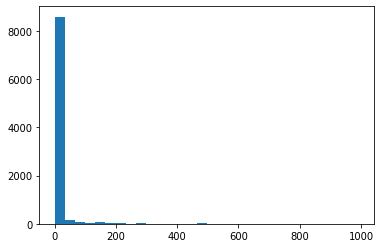

In [33]:
plt.hist(max_nan_list,bins=30)

we selected 30 as threshold for removing products with consecutive nan. After removing, we have 8510 rows left. 

In [34]:
bsr_timelines_by_product['max_consec_nan'] = max_nan_list
bsr_timelines_by_product = bsr_timelines_by_product[bsr_timelines_by_product['max_consec_nan'] < 30]
bsr_timelines_by_product.reset_index(drop=True, inplace=True)

In [35]:
print(bsr_timelines_by_product.shape)
print("max consecutive nan:", max(bsr_timelines_by_product['max_consec_nan']))

(8510, 4)
max consecutive nan: 29


In [36]:
bsr_timelines_by_product['filled_rank'] = bsr_timelines_by_product['rank'].apply(fill_na)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## After fill NA

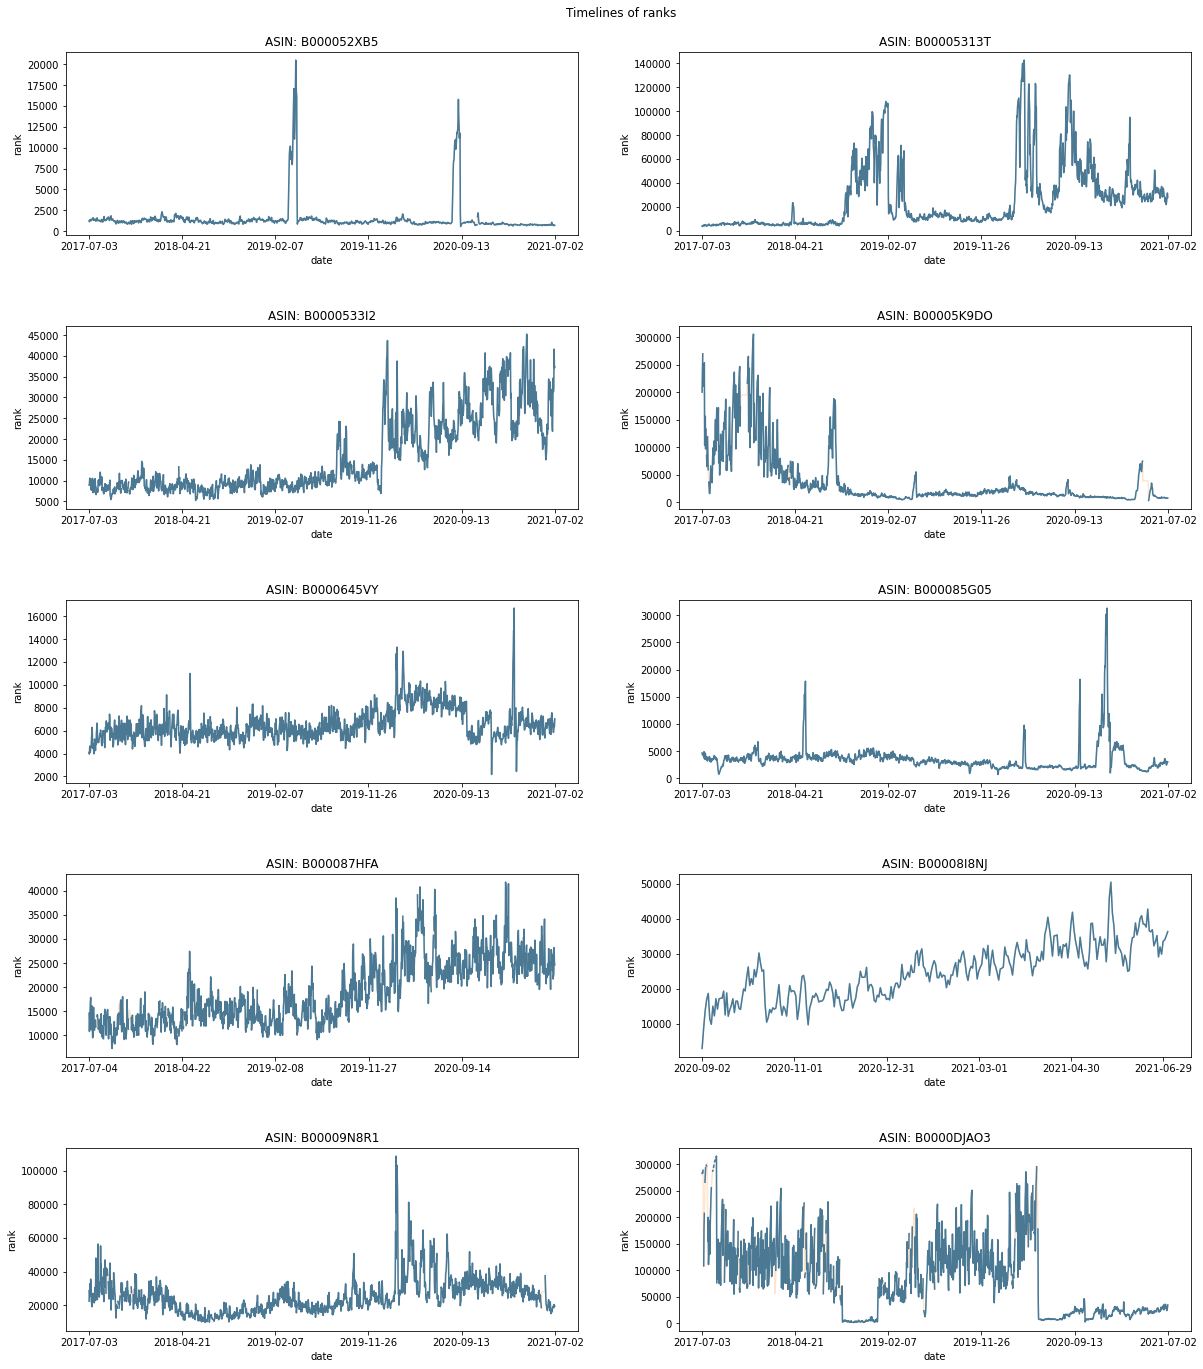

In [37]:
# Plotting product ranks over time
PLOT_NUMBER = 10
f, axs = plt.subplots(PLOT_NUMBER//2,2,figsize=(18,2*PLOT_NUMBER));
axs = axs.ravel()
f.suptitle('Timelines of ranks')
f.tight_layout(pad=7.0)
for i in range(PLOT_NUMBER):
  axs[i].plot(bsr_timelines_by_product['date'][i],
              bsr_timelines_by_product['rank'][i])
  axs[i].plot(bsr_timelines_by_product['date'][i],
              bsr_timelines_by_product['filled_rank'][i], alpha = 0.2)
  axs[i].set(title=f"ASIN: {bsr_timelines_by_product['asin'][i]}",
             xlabel='date',
             ylabel='rank')
  axs[i].set_xticks(axs[i].get_xticks()[::len(axs[i].get_xticks())//5])

# Smoothing
Moving average

In [38]:
bsr_timelines_by_product['rolling_median_rank_10d'] = bsr_timelines_by_product['filled_rank'].apply(smoothing)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [39]:
bsr_timelines_by_product['n_rolling_median_rank_10d'] = bsr_timelines_by_product['rolling_median_rank_10d'].apply(normalize)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


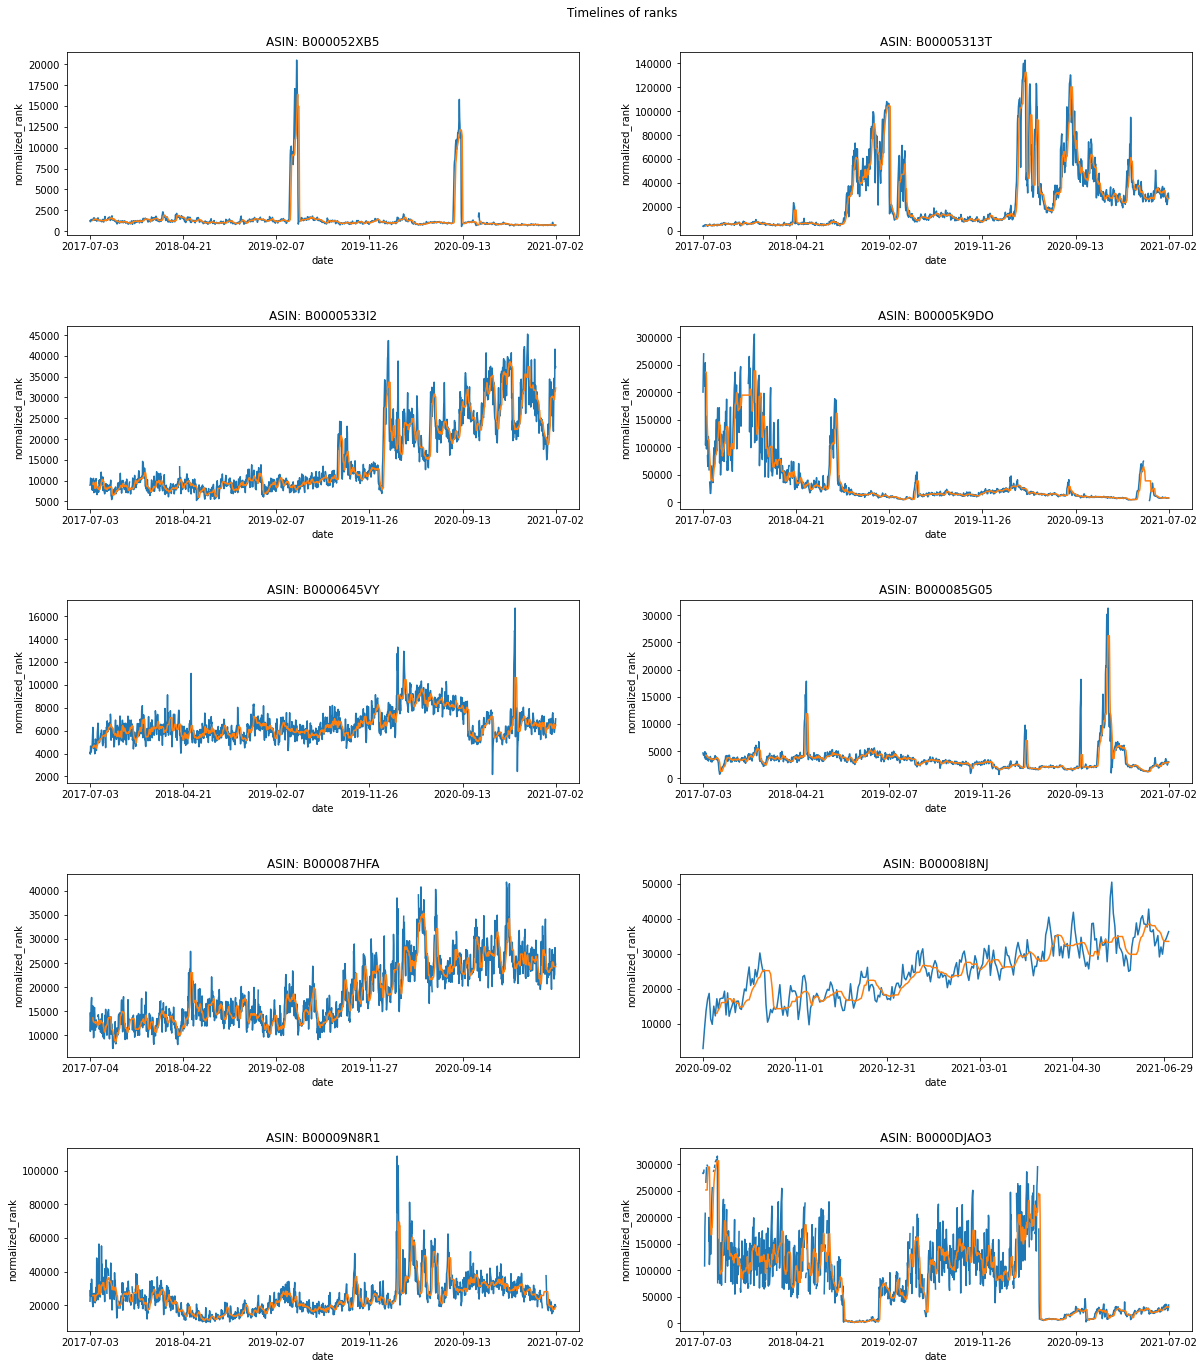

In [40]:
PLOT_NUMBER = 10
f, axs = plt.subplots(PLOT_NUMBER//2,2,figsize=(18,2*PLOT_NUMBER));
axs = axs.ravel()
f.suptitle('Timelines of ranks')
f.tight_layout(pad=7.0)
for i in range(PLOT_NUMBER):
  axs[i].plot(bsr_timelines_by_product['date'][i],
              bsr_timelines_by_product['rank'][i]),
  axs[i].plot(bsr_timelines_by_product['date'][i],
              bsr_timelines_by_product['rolling_median_rank_10d'][i])
  axs[i].set(title=f"ASIN: {bsr_timelines_by_product['asin'][i]}",
             xlabel='date',
             ylabel='normalized_rank')
  axs[i].set_xticks(axs[i].get_xticks()[::len(axs[i].get_xticks())//5])

In [41]:
bsr_timelines_by_product = bsr_timelines_by_product.drop(columns=['max_consec_nan'])

In [42]:
bsr_timelines_by_product

,asin,rank,date,filled_rank,rolling_median_rank_10d,n_rolling_median_rank_10d
0,B000052XB5,"[1254.1666666666667, 1137.0, 1216.0, 1345.8571...","[2017-07-03, 2017-07-04, 2017-07-05, 2017-07-0...","[1254.1666666666667, 1137.0, 1216.0, 1345.8571...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
1,B00005313T,"[3805.75, 4089.0, 3478.125, 4052.571428571429,...","[2017-07-03, 2017-07-04, 2017-07-05, 2017-07-0...","[3805.75, 4089.0, 3478.125, 4052.571428571429,...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
2,B0000533I2,"[8918.0, 9200.0, 10612.333333333334, 9628.0, 9...","[2017-07-03, 2017-07-04, 2017-07-05, 2017-07-0...","[8918.0, 9200.0, 10612.333333333334, 9628.0, 9...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
3,B00005K9DO,"[199998.5, 232356.0, 269494.0, nan, nan, nan, ...","[2017-07-03, 2017-07-04, 2017-07-05, 2017-07-0...","[199998.5, 232356.0, 269494.0, 240084.5, 24008...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
4,B0000645VY,"[4093.75, 3950.857142857143, 4651.75, 4122.142...","[2017-07-03, 2017-07-04, 2017-07-05, 2017-07-0...","[4093.75, 3950.857142857143, 4651.75, 4122.142...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
...,...,...,...,...,...,...
8505,B08PDXQJG4,"[114812.0, 206618.0, 161748.66666666666, nan, ...","[2020-12-03, 2020-12-04, 2020-12-05, 2020-12-0...","[114812.0, 206618.0, 161748.66666666666, 15341...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
8506,B08PH5ZHVC,"[176613.0, 174651.0, 225566.0, 125644.2, 11249...","[2020-12-11, 2020-12-12, 2020-12-13, 2020-12-1...","[176613.0, 174651.0, 225566.0, 125644.2, 11249...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
8507,B08PQC9VRP,"[191472.3333333333, 135016.33333333334, 194566...","[2020-12-07, 2020-12-08, 2020-12-09, 2020-12-1...","[191472.3333333333, 135016.33333333334, 194566...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
8508,B08Q2CTFJ3,"[138366.0, 86092.5, 108362.0, 71956.5, 58127.3...","[2020-12-11, 2020-12-12, 2020-12-13, 2020-12-1...","[138366.0, 86092.5, 108362.0, 71956.5, 58127.3...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."


Computed the monthly mean

In [43]:
date_df = pd.DataFrame(zip(bsr_timelines_by_product['date'][0], bsr_timelines_by_product['filled_rank'][0]), columns=['Date','filled_rank'])
date_df['YearMonth'] = pd.to_datetime(date_df['Date'].apply(pd.to_datetime).apply(lambda x: x.strftime('%m-%Y')))

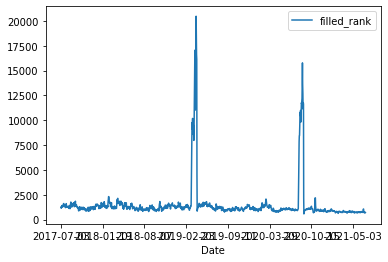

In [44]:
date_df.plot('Date','filled_rank')

In [45]:
date_df_new = date_df.groupby('YearMonth').mean().reset_index().sort_values(by='YearMonth')
date_df_new['YearMonth']= date_df_new['YearMonth'].dt.strftime('%m-%Y')

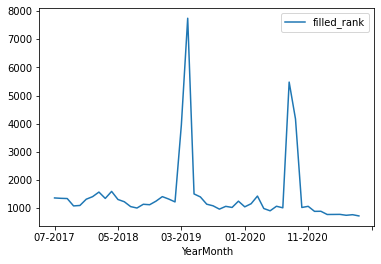

In [46]:
date_df_new.plot('YearMonth','filled_rank')

In [47]:
date, rank, rolling_rank = bsr_timelines_by_product.iloc[0]['date'], bsr_timelines_by_product.iloc[0]['filled_rank'], bsr_timelines_by_product.iloc[0]['n_rolling_median_rank_10d']

In [48]:
month_rank = bsr_timelines_by_product.apply(lambda x: get_monthly_data(x.date, x.filled_rank, x.n_rolling_median_rank_10d), axis=1)

In [49]:
year_month = []
mean_month_rank = []
median_month_rank = []
rolling_median_month_rank = []
dates_in_month = []
for row in month_rank:
  year_month.append(row[0])
  mean_month_rank.append(row[1])
  median_month_rank.append(row[2])
  rolling_median_month_rank.append(row[3])
  dates_in_month.append(row[4])

In [50]:
bsr_timelines_by_product['year_month'] = year_month
bsr_timelines_by_product['mean_month_rank'] = mean_month_rank
bsr_timelines_by_product['median_month_rank'] = median_month_rank
bsr_timelines_by_product['dates_in_month'] = dates_in_month
bsr_timelines_by_product['rolling_median_month_rank'] = rolling_median_month_rank

In [51]:
bsr_timelines_by_product

,asin,rank,date,filled_rank,rolling_median_rank_10d,n_rolling_median_rank_10d,year_month,mean_month_rank,median_month_rank,dates_in_month,rolling_median_month_rank
0,B000052XB5,"[1254.1666666666667, 1137.0, 1216.0, 1345.8571...","[2017-07-03, 2017-07-04, 2017-07-05, 2017-07-0...","[1254.1666666666667, 1137.0, 1216.0, 1345.8571...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[07-2017, 08-2017, 09-2017, 10-2017, 11-2017, ...","[1361.8128078817733, 1348.406797235023, 1340.8...","[1345.857142857143, 1306.857142857143, 1301.92...","[[2017-07-03, 2017-07-04, 2017-07-05, 2017-07-...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
1,B00005313T,"[3805.75, 4089.0, 3478.125, 4052.571428571429,...","[2017-07-03, 2017-07-04, 2017-07-05, 2017-07-0...","[3805.75, 4089.0, 3478.125, 4052.571428571429,...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[07-2017, 08-2017, 09-2017, 10-2017, 11-2017, ...","[4403.991789819376, 4873.626843317972, 5645.31...","[4391.857142857143, 4791.857142857143, 5583.33...","[[2017-07-03, 2017-07-04, 2017-07-05, 2017-07-...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
2,B0000533I2,"[8918.0, 9200.0, 10612.333333333334, 9628.0, 9...","[2017-07-03, 2017-07-04, 2017-07-05, 2017-07-0...","[8918.0, 9200.0, 10612.333333333334, 9628.0, 9...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[07-2017, 08-2017, 09-2017, 10-2017, 11-2017, ...","[8680.080459770115, 8862.798387096775, 7607.85...","[8511.75, 8628.75, 7612.125, 8535.25, 9164.15,...","[[2017-07-03, 2017-07-04, 2017-07-05, 2017-07-...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
3,B00005K9DO,"[199998.5, 232356.0, 269494.0, nan, nan, nan, ...","[2017-07-03, 2017-07-04, 2017-07-05, 2017-07-0...","[199998.5, 232356.0, 269494.0, 240084.5, 24008...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[07-2017, 08-2017, 09-2017, 10-2017, 11-2017, ...","[119882.04310344828, 101592.5623655914, 111303...","[103538.0, 93593.0, 110549.5, 170043.5, 194514...","[[2017-07-03, 2017-07-04, 2017-07-05, 2017-07-...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
4,B0000645VY,"[4093.75, 3950.857142857143, 4651.75, 4122.142...","[2017-07-03, 2017-07-04, 2017-07-05, 2017-07-0...","[4093.75, 3950.857142857143, 4651.75, 4122.142...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[07-2017, 08-2017, 09-2017, 10-2017, 11-2017, ...","[4910.38341543514, 5666.1228878648235, 5921.34...","[4804.875, 5670.714285714285, 5798.5, 5952.642...","[[2017-07-03, 2017-07-04, 2017-07-05, 2017-07-...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
...,...,...,...,...,...,...,...,...,...,...,...
8505,B08PDXQJG4,"[114812.0, 206618.0, 161748.66666666666, nan, ...","[2020-12-03, 2020-12-04, 2020-12-05, 2020-12-0...","[114812.0, 206618.0, 161748.66666666666, 15341...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[12-2020, 01-2021, 02-2021, 03-2021, 04-2021, ...","[87949.69252873564, 49473.562365591395, 34503....","[78110.0, 48003.333333333336, 33814.1666666666...","[[2020-12-03, 2020-12-04, 2020-12-05, 2020-12-...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
8506,B08PH5ZHVC,"[176613.0, 174651.0, 225566.0, 125644.2, 11249...","[2020-12-11, 2020-12-12, 2020-12-13, 2020-12-1...","[176613.0, 174651.0, 225566.0, 125644.2, 11249...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[12-2020, 01-2021, 02-2021, 03-2021, 04-2021, ...","[89527.56279289493, 128861.94592933948, 30901....","[72584.14285714286, 110666.5, 15418.4107142857...","[[2020-12-11, 2020-12-12, 2020-12-13, 2020-12-...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,..."
8507,B08PQC9VRP,"[191472.3333333333, 135016.3333333

# Normalization 

Normalize product BSR against its best performance: i.e. for each product, first compute its maximum and minimum BSR observed in the dataset; then, for product i on date t, compute (BSR_{i,t} - min BSR)/(max BSR - min BSR) to represent product i's performance compared with its past performance.

In [52]:
bsr_timelines_by_product['n_mean_month_rank'] = bsr_timelines_by_product['mean_month_rank'].apply(normalize)
bsr_timelines_by_product['n_median_month_rank'] = bsr_timelines_by_product['median_month_rank'].apply(normalize)

In [53]:
bsr_timelines_by_product.columns

Index(['asin', 'rank', 'date', 'filled_rank', 'rolling_median_rank_10d',
       'n_rolling_median_rank_10d', 'year_month', 'mean_month_rank',
       'median_month_rank', 'dates_in_month', 'rolling_median_month_rank',
       'n_mean_month_rank', 'n_median_month_rank'],
      dtype='object')

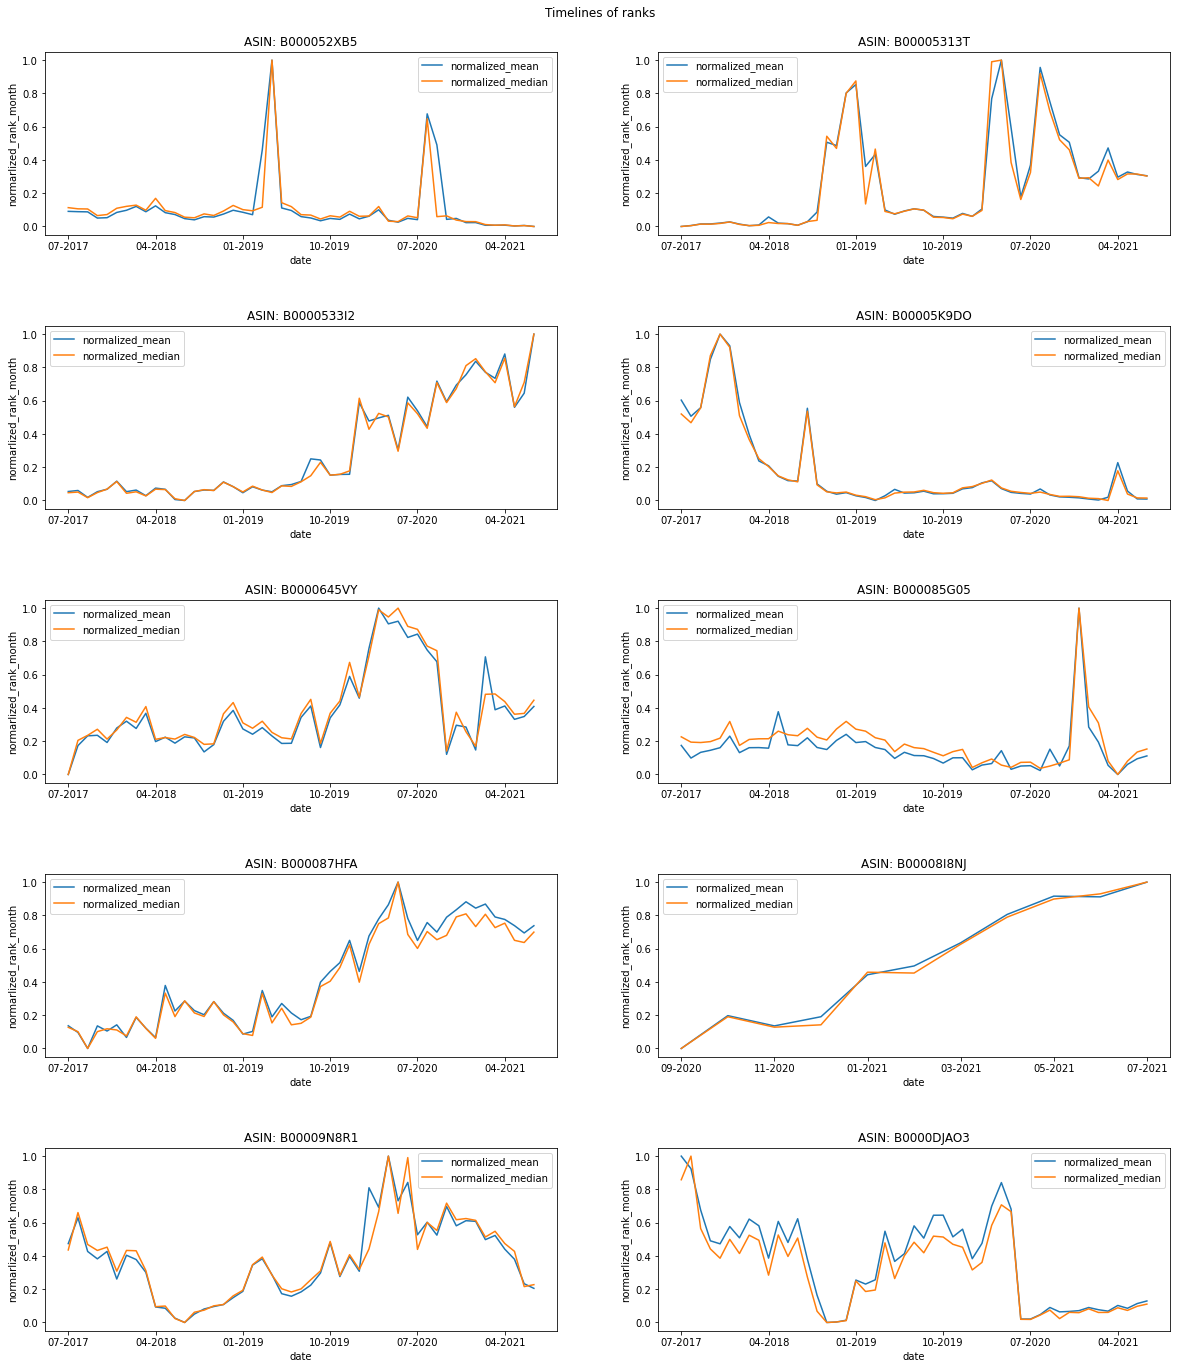

In [54]:
PLOT_NUMBER = 10
f, axs = plt.subplots(PLOT_NUMBER//2,2,figsize=(18,2*PLOT_NUMBER));
axs = axs.ravel()
f.suptitle('Timelines of ranks')
f.tight_layout(pad=7.0)
for i in range(PLOT_NUMBER):
  axs[i].plot(bsr_timelines_by_product['year_month'][i],
              bsr_timelines_by_product['n_mean_month_rank'][i], label='normalized_mean')
  axs[i].plot(bsr_timelines_by_product['year_month'][i],
              bsr_timelines_by_product['n_median_month_rank'][i],label='normalized_median')
  axs[i].set(title=f"ASIN: {bsr_timelines_by_product['asin'][i]}",
             xlabel='date',
             ylabel='normarlized_rank_month')
  axs[i].set_xticks(axs[i].get_xticks()[::len(axs[i].get_xticks())//5])
  axs[i].legend()

In [55]:
bsr_rank = bsr_timelines_by_product[['asin', 'year_month','n_mean_month_rank','n_median_month_rank','dates_in_month','rolling_median_month_rank']]

In [56]:
# get monthly data - asin - month - month_medien - month rank - moving average for the whole month
df_temp_list = []
for i in range(len(bsr_rank)):
  temp = bsr_rank.iloc[i]
  df_temp = pd.DataFrame({'asin' : temp['asin'],
              'year_month' : temp['year_month'],
              'mean_month_rank' : temp['n_mean_month_rank'],
              'median_month_rank' : temp['n_mean_month_rank'],
              'dates_in_month' : temp['dates_in_month'],
              'rolling_median_month_rank' : temp['rolling_median_month_rank'],
              })
  df_temp_list.append(df_temp)

In [57]:
df_full = pd.concat(df_temp_list)
df_full.reset_index(drop=True, inplace=True)

In [58]:
df_full

,asin,year_month,mean_month_rank,median_month_rank,dates_in_month,rolling_median_month_rank
0,B000052XB5,07-2017,0.090908,0.090908,"[2017-07-03, 2017-07-04, 2017-07-05, 2017-07-0...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
1,B000052XB5,08-2017,0.088999,0.088999,"[2017-08-01, 2017-08-02, 2017-08-03, 2017-08-0...","[0.03545335800240161, 0.03545335800240161, 0.0..."
2,B000052XB5,09-2017,0.087918,0.087918,"[2017-09-01, 2017-09-02, 2017-09-03, 2017-09-0...","[0.04527607163235586, 0.04999352908399204, 0.0..."
3,B000052XB5,10-2017,0.050594,0.050594,"[2017-10-01, 2017-10-02, 2017-10-03, 2017-10-0...","[0.02781543396350373, 0.026825406625974667, 0...."
4,B000052XB5,11-2017,0.052829,0.052829,"[2017-11-01, 2017-11-02, 2017-11-03, 2017-11-0...","[0.017099642677690898, 0.017099642677690898, 0..."
...,...,...,...,...,...,...
323776,B08QBXMHRT,03-2021,0.046404,0.046404,"[2021-03-01, 2021-03-02, 2021-03-03, 2021-03-0...","[0.06401577563757907, 0.010474309769398688, 0...."
323777,B08QBXMHRT,04-2021,0.013760,0.013760,"[2021-04-01, 2021-04-02, 2021-04-03, 2021-04-0...","[0.0361917395322562, 0.0361917395322562, 0.038..."
323778,B08QBXMHRT,05-2021,0.027598,0.027598,"[2021-05-01, 2021-05-02, 2021-05-03, 2021-05-0...","[0.009477461428107754, 0.010802458888445655, 0..."
323779,B08QBXMHRT,06-2021,0.021938,0.021938,"[2021-06-01, 2021-06-02, 2021-06-03, 2021-06-0...","[0.0, 0.00231784428526475, 0.00654631971991863..."


In [59]:
df_full.to_pickle(f'{out_data}/month_level_rank.pickle')
# bsr_timelines_by_product.to_pickle(f'{out_data}/normalized_monthly_rank.pickle')

In [60]:
df_full

,asin,year_month,mean_month_rank,median_month_rank,dates_in_month,rolling_median_month_rank
0,B000052XB5,07-2017,0.090908,0.090908,"[2017-07-03, 2017-07-04, 2017-07-05, 2017-07-0...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
1,B000052XB5,08-2017,0.088999,0.088999,"[2017-08-01, 2017-08-02, 2017-08-03, 2017-08-0...","[0.03545335800240161, 0.03545335800240161, 0.0..."
2,B000052XB5,09-2017,0.087918,0.087918,"[2017-09-01, 2017-09-02, 2017-09-03, 2017-09-0...","[0.04527607163235586, 0.04999352908399204, 0.0..."
3,B000052XB5,10-2017,0.050594,0.050594,"[2017-10-01, 2017-10-02, 2017-10-03, 2017-10-0...","[0.02781543396350373, 0.026825406625974667, 0...."
4,B000052XB5,11-2017,0.052829,0.052829,"[2017-11-01, 2017-11-02, 2017-11-03, 2017-11-0...","[0.017099642677690898, 0.017099642677690898, 0..."
...,...,...,...,...,...,...
323776,B08QBXMHRT,03-2021,0.046404,0.046404,"[2021-03-01, 2021-03-02, 2021-03-03, 2021-03-0...","[0.06401577563757907, 0.010474309769398688, 0...."
323777,B08QBXMHRT,04-2021,0.013760,0.013760,"[2021-04-01, 2021-04-02, 2021-04-03, 2021-04-0...","[0.0361917395322562, 0.0361917395322562, 0.038..."
323778,B08QBXMHRT,05-2021,0.027598,0.027598,"[2021-05-01, 2021-05-02, 2021-05-03, 2021-05-0...","[0.009477461428107754, 0.010802458888445655, 0..."
323779,B08QBXMHRT,06-2021,0.021938,0.021938,"[2021-06-01, 2021-06-02, 2021-06-03, 2021-06-0...","[0.0, 0.00231784428526475, 0.00654631971991863..."


In [61]:
df_full = pd.read_pickle(f'{out_data}/month_level_rank.pickle')

In [62]:
for i in [0,2345,13324,43544,200000,204354,280936]:
    print(len(df_full.loc[i]['year_month']), len(df_full.loc[i]['dates_in_month']), len(df_full.loc[i]['rolling_median_month_rank']))

7 29 29
7 31 31
7 31 31
7 30 30
7 31 31
7 31 31
7 28 28
